# Inference Test Code for CLIP

In [28]:
from transformers import DistilBertTokenizer
import cv2
from dataset import get_transforms
from CLIP import CLIPModel
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

### model load

In [32]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [38]:
# model_path = "/data/yuto/clip/OpenAI-CLIP/output/resnet_text_encoder_fix/checkpoints/checkpoint_9.pth"
model_path = "/data/yuto/clip/OpenAI-CLIP/output/resnet_text_encoder_fix/checkpoints/checkpoint_3.pth"

model = CLIPModel().to("cuda")
model.load_state_dict(torch.load(model_path, map_location="cuda"))
model.eval()

CLIPModel(
  (image_encoder): ImageEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

In [41]:
text = tokenizer(["a diagram", "a dog", "a cat", "noodle"])
batch = {key: torch.tensor(values).to("cuda") for key, values in text.items()}
print(batch)
text_features = model.text_encoder(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
text_embeddings = model.text_projection(text_features)

{'input_ids': tensor([[  101,  1037, 16403,   102],
        [  101,  1037,  3899,   102],
        [  101,  1037,  4937,   102],
        [  101,  2053, 26156,   102]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1],
        [1, 1, 1, 1]], device='cuda:0')}


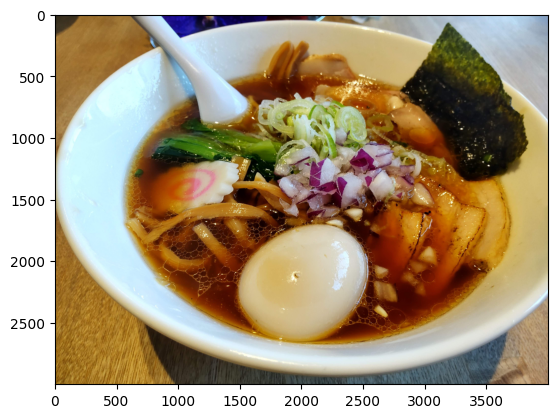

In [42]:
transforms = get_transforms(mode='valid')

filename = "/data/yuto/clip/OpenAI-CLIP/ramen.jpg"
image = cv2.imread(filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

image = transforms(image=image)['image']
image = torch.tensor(image).permute(2, 0, 1).float().unsqueeze(0)

image_features = model.image_encoder(image.to("cuda"))
image_embeddings = model.image_projection(image_features)

### Matching between image embeddings and text embedings

In [55]:
# L2ノルムで normalization
# dim=-1 means normalization along with last dimention that is embedding
print(text_embeddings.shape)
image_embeddings_n = F.normalize(image_embeddings, dim=-1)
text_embeddings_n = F.normalize(text_embeddings, dim=-1) # shape: (n, 256)
# print(sum(text_embeddings_n[0]*text_embeddings_n[0]) is 1

similarity = 100 * image_embeddings_n @ text_embeddings_n.T
print(similarity)

# Why do you multiply by 100?
# why is 100 bultiplyed
text_probs = (100 * image_embeddings_n @ text_embeddings_n.T).softmax(dim=-1)

print("Label probs:", text_probs)

torch.Size([4, 256])
tensor([[41.4968, 38.2700, 36.0218, 49.5118]], device='cuda:0',
       grad_fn=<MmBackward0>)
Label probs: tensor([[3.3038e-04, 1.3111e-05, 1.3844e-06, 9.9966e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
